# Garbage Classification

# Imports

In [ ]:
# !pip uninstall tf-keras
# !pip install tensorflow==2.16.1

In [1]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.3.3 Tensorflow Current Version: 2.16.1


In [2]:
from glob import glob
import random, os, datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models  import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, AUC

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Functions

In [3]:
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ['*.jpg', '*.jpeg', '*.png']:
        all_images.extend(glob(os.path.join(root_dir, '**', extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))


def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(img_list):
        img = image.load_img(img_path)
        img = image.img_to_array(img, dtype=np.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze())
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()


# Data Understanding

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/Garbage classification'

In [5]:
img_list = get_image_paths(dir_path)

print(len(img_list))

2527


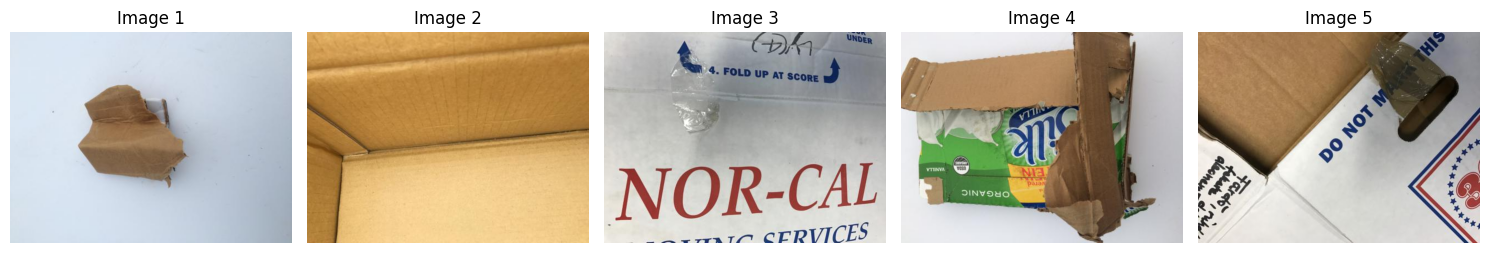

In [13]:
display_images(img_list[0:5])

# Data Preparation & Augmentation

In [6]:
train = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

val = ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)


In [7]:
train_generator=train.flow_from_directory(dir_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

validation_generator=val.flow_from_directory(dir_path,
                                        target_size=(224, 224),
                                        batch_size=251,
                                        class_mode='categorical',
                                        subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [16]:
train_images, train_labels = next(train_generator)
print("First 5 labels from the training set:")
print(train_labels[:5])

First 5 labels from the training set:
[[0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


# Model

In [8]:
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])


metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True)]


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)


early_stopping = EarlyStopping(monitor='val_loss',
                           patience=10,
                           verbose=1,
                           restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath='garbage_model.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

In [9]:
start_time = datetime.datetime.now()

history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.2900 - auc: 0.5997 - loss: 3.0729
Epoch 1: val_loss improved from inf to 1.45074, saving model to garbage_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 584ms/step - accuracy: 0.2908 - auc: 0.6005 - loss: 3.0578 - val_accuracy: 0.4422 - val_auc: 0.7524 - val_loss: 1.4507
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.4443 - auc: 0.7768 - loss: 1.3689
Epoch 2: val_loss improved from 1.45074 to 1.38323, saving model to garbage_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 410ms/step - accuracy: 0.4445 - auc: 0.7768 - loss: 1.3687 - val_accuracy: 0.4661 - val_auc: 0.8029 - val_loss: 1.3832
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.4048 - auc: 0.7729 - loss: 1.3959
Epoch 3: val_loss did not improve from 1.38323
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 375ms/step - accuracy: 0.4052 - auc: 0.7729 - loss: 1.3958 - val_accuracy: 0.4303 - val_auc: 0.7893 - val_loss: 1.4664
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3

# Model Performance

## Model Performance Plot

In [14]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

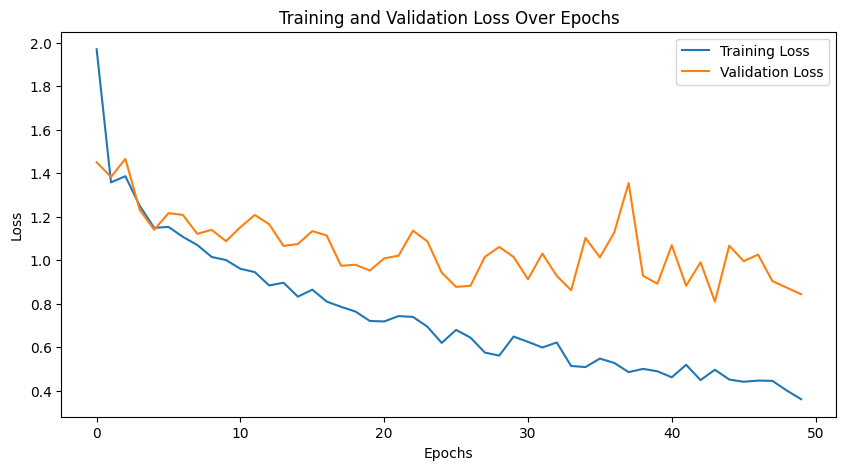

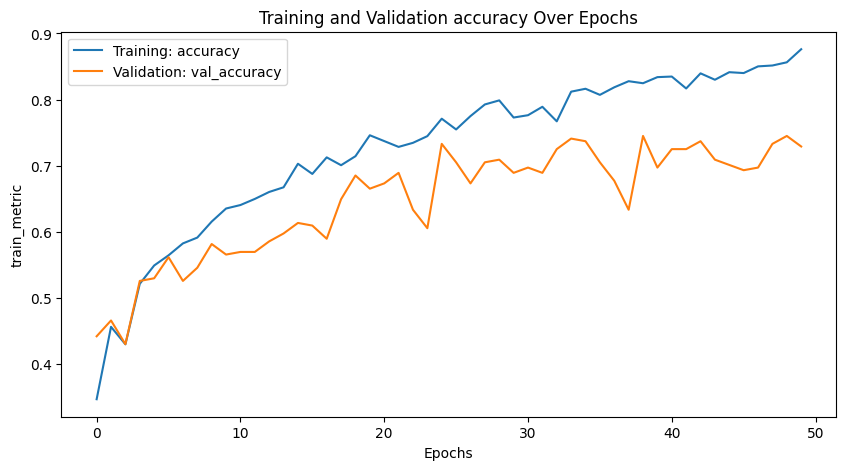

In [15]:
plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy')

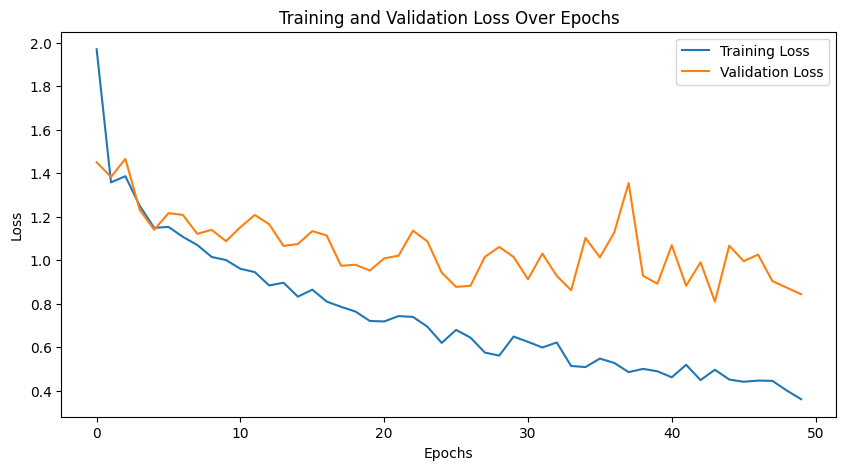

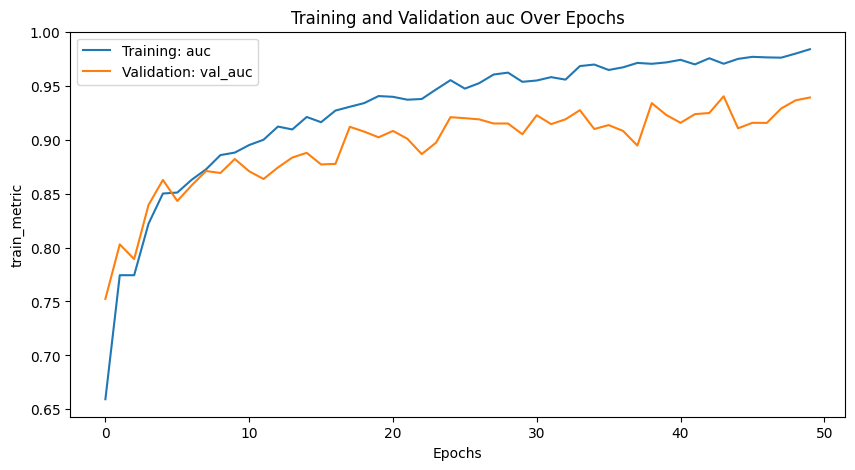

In [16]:
plot_training_history(history, train_loss='loss', train_metric='auc', val_loss='val_loss', val_metric='val_auc')

## Model Performance Numeric

In [17]:
val_loss, val_accuracy, val_auc = model.evaluate(validation_generator, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 0.8097310662269592
Accuracy: 0.7091633677482605
AUC: 0.9401740431785583


# Prediction

In [19]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [20]:
im_dir = "/content/drive/MyDrive/Colab Notebooks/Garbage classification"

In [21]:
images_paths = [im_dir + "/metal/metal10.jpg", im_dir + "/glass/glass104.jpg", im_dir + "/plastic/plastic100.jpg", im_dir + "/trash/trash103.jpg"]

In [22]:
garbage_model = load_model('/content/garbage_model.keras')

In [23]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)

    img_array = image.img_to_array(img) / 255.0

    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

In [24]:
def prediction_probs(img_array, model, waste_labels):

    predictions = model.predict(img_array, verbose = 0)

    predicted_class_idx = np.argmax(predictions[0])

    predicted_class = waste_labels.get(predicted_class_idx, 'Unknown')

    max_probability = np.max(predictions[0])

    return max_probability, predicted_class

In [25]:
def display_images(image_paths, model, waste_labels):
    # dynamic display
    num_images = len(image_paths)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols
    plt.figure(figsize=(num_cols * 5, num_rows * 5))

    for i, path in enumerate(image_paths):
        img, img_array = preprocess_image(path)

        probability, predicted_class = prediction_probs(img_array, model, waste_labels)

        ax = plt.subplot(num_rows, num_cols, i + 1)
        img = image.img_to_array(img)
        plt.imshow(img.astype('uint8'))
        plt.title(f"Max Probability: {probability:.2f}\nPredicted Class: {predicted_class}")
        plt.axis('off')
    plt.show()

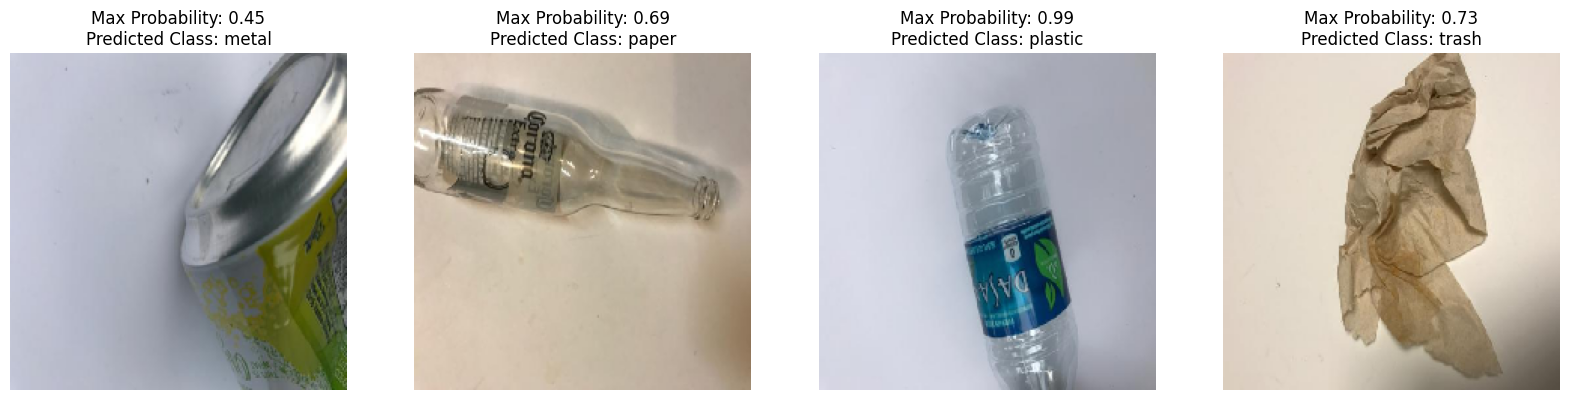

In [26]:
display_images(images_paths, garbage_model, waste_labels)

In [27]:
get_image_paths(im_dir, 10)

['/content/drive/MyDrive/Colab Notebooks/Garbage classification/plastic/plastic175.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard104.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/glass/glass10.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/metal/metal4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/metal/metal9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/paper/paper331.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/glass/glass373.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/paper/paper339.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/glass/glass482.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Garbage classification/metal/metal247.jpg']

In [28]:
random_images_path = get_image_paths(im_dir, 10)

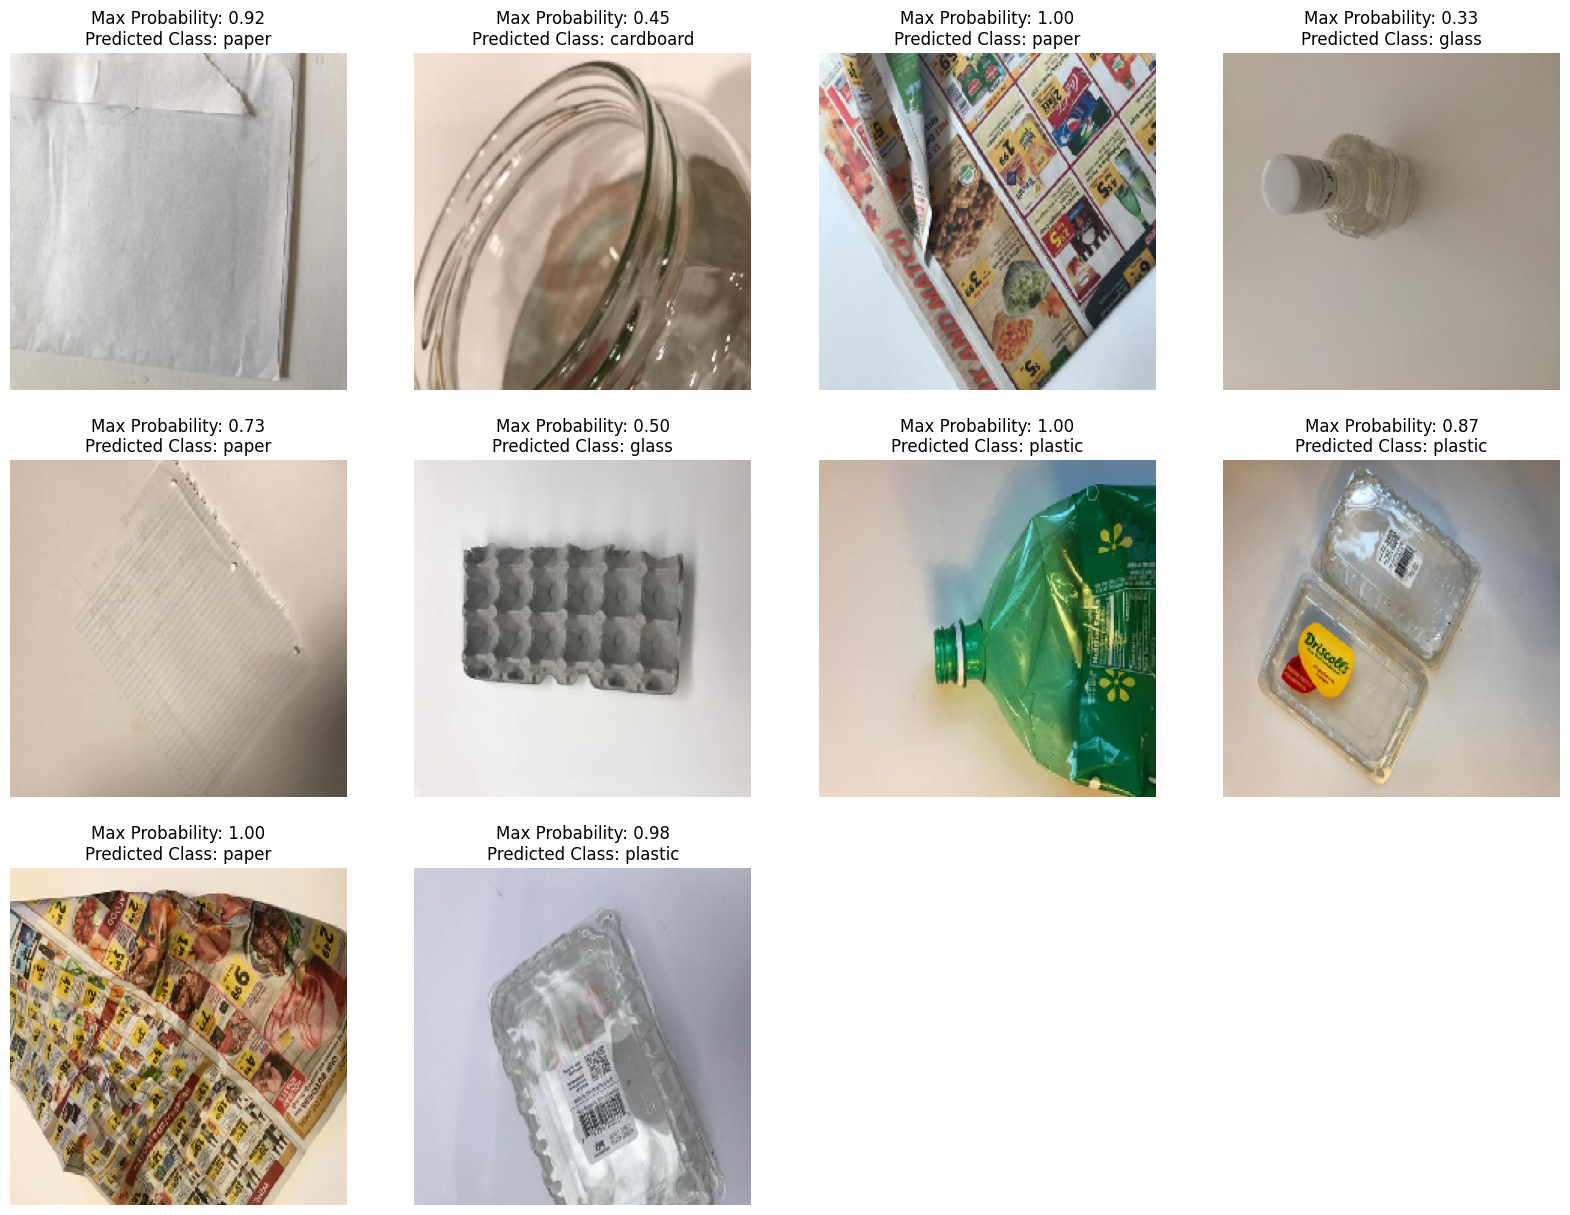

In [29]:
display_images(random_images_path, garbage_model, waste_labels)